In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import datetime
from functools import reduce
from collections import Counter
import re
# from tqdm import tqdm_notebook

%matplotlib inline

# Loading CryptoPanic data from server with Mongo

In [1]:
PATH_TO_DATA = 'data/'
file_news='news4.pkl'
file_votes='votes4.pkl'

In [2]:
def load_db(file_news=PATH_TO_DATA+file_news, file_votes=PATH_TO_DATA+file_votes):
    '''
    load DB from server
    save all votes (with updates) to `file_votes`
    save unique news to `file_news`
    '''
    from sshtunnel import SSHTunnelForwarder
    import pymongo
    
    MONGO_HOST = "148.251.21.37"
    MONGO_DB = "cryptopanic_latest"
    MONGO_USER = "andrii"
    MONGO_PASS = "andrii"

    server = SSHTunnelForwarder(
        MONGO_HOST,
        ssh_username=MONGO_USER,
        ssh_password=MONGO_PASS,
        remote_bind_address=('127.0.0.1', 27017)
    )

    server.start()

    try:
        client = pymongo.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
        db = client["cryptopanic_latest"]
        collection = db['new_parsed']
        
        # loading news from remote database
        cursor_news = collection.find({'new_post':True})
        list_news = []
        for i, x in enumerate(cursor_news):
            list_news.append(x)
            if i % 100000 == 0:
                print(i, 'news loaded')
        print('total', len(list_news), 'news')
        pickle.dump(list_news, open(file_news, 'wb'))
        
        # loading votes from remote database
        cursor_votes = collection.find(projection=['id', 'votes', 'date_modified', 'new_post'])
        list_votes = []
        for i, x in enumerate(cursor_votes):
            list_votes.append(x)
            if i % 100000 == 0:
                print(i, 'updates loaded')
        print('total', len(list_votes), 'updates')
        pickle.dump(list_votes, open(file_votes, 'wb'))

    except Exception as e:
        print(e)
    
    server.stop()

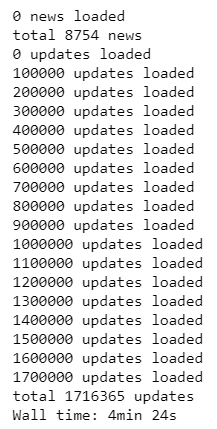

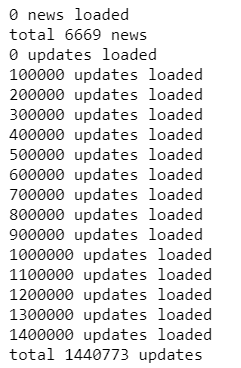

In [6]:
def to_datetime(iterable, pattern='%Y-%m-%dT%H:%M', period_seconds=5*60):
    '''
    patterns:
    '%m/%d/%Y %H:%M' for `date_modified`
    '%Y-%m-%dT%H:%M' for `created_at`
    '''
    dates = np.array([datetime.datetime.strptime(date_str[:16], pattern) for date_str in iterable])
    dates = np.array([datetime.datetime.fromtimestamp((date.timestamp() // period_seconds) * period_seconds) for date in dates])
    return dates

In [7]:
def _drop_duplicates(df_news):
    return df_news.drop_duplicates(subset=['id'])

In [8]:
def get_news_and_votes(file_news=PATH_TO_DATA+file_news, file_votes=PATH_TO_DATA+file_votes, currencies=['None', 'BTC'],
                       drop_duplicates=True):    
    '''
    returns dataframes for news and votes using DB saved in .pkl files
    '''
    news = pickle.load(open(file_news, 'rb'))
    df_news = pd.DataFrame(news)
    if drop_duplicates:
        df_news = _drop_duplicates(df_news)
    df_news = df_news.loc[:, ['_id', 'created_at', 'currencies', 'id', 'title']]
    # replacing `currencies` column with corresponding currencies columns
    code = []
    for record in df_news['currencies'].values:
        if type(record) == list:
            l = []
            for currency in record: 
                l.append(currency['code'])
            code.append(l)
        else:
            code.append(np.nan)
    df_news['currency_code'] = code

    currencies_names = set()
    for record in df_news.currency_code.values:
        if type(record) == list:
            for cur in record:
                currencies_names.add(cur)
    currencies_names = list(currencies_names)

    dic = dict()
    for cur in currencies_names:
        dic[cur] = []
        for record in df_news.currency_code.values:
            if type(record) == list:
                if cur in record:
                    dic[cur].append(1)
                else:
                    dic[cur].append(0)
            else:
                dic[cur].append(0)   

    for key, value in dic.items():
        df_news['currency_'+key] = value

    df_news.drop(['currencies', 'currency_code'], axis=1, inplace=True)

    df_news['currency_None'] = (df_news[['currency_'+key for key, value in dic.items()]].values.sum(axis=1) == 0).astype(int)

    # drop redundant currencies columns
    if currencies != []:
        if len(currencies) > 1:
            index = reduce((lambda x, y: (df_news['currency_'+x] == 1) | (df_news['currency_'+y] == 1)), currencies)
        else:
            index = (df_news['currency_'+currencies[0]] == 1)
        df_news = df_news[index]
        df_news = df_news.loc[:,['_id', 'created_at', 'id', 'title']+['currency_'+currency for currency in currencies]]
    
    
    votes = pickle.load(open(file_votes, 'rb'))
    df_votes = pd.DataFrame(votes)
    # drop redundant currencies rows
    df_votes = df_votes[np.isin(df_votes.id.values, df_news.id.values)]
    # replacing `votes` column with corresponding reactions columns
    list_votes = []
    for record in df_votes['votes'].values:
        if type(record) == dict:
            list_votes.append(list(record.values()))
        else:
            list_votes.append(np.nan)
    list_votes = np.array(list_votes)

    for i, column_name in enumerate(["lol", "toxic", "disliked", "negative", "saved", "liked", "positive", "important"]):
        df_votes['votes_' + column_name] = list_votes[:, i]
    df_votes.drop('votes', axis=1, inplace=True)
    
    return df_news, df_votes


def save_news_and_votes(df_news, df_votes, file_news=PATH_TO_DATA+'df_'+file_news, file_votes=PATH_TO_DATA+'df_'+file_votes):
    '''
    save dataframes to .pkl
    '''
    pickle.dump(df_news, open(file_news, 'wb'))
    pickle.dump(df_votes, open(file_votes, 'wb'))
    
    
def load_news_and_votes(file_news=PATH_TO_DATA+'df_'+file_news, file_votes=PATH_TO_DATA+'df_'+file_votes):
    '''
    save dataframes to .pkl
    '''
    df_news = pickle.load(open(file_news, 'rb'))
    df_votes = pickle.load(open(file_votes, 'rb'))
    return df_news, df_votes

In [13]:
df_news, df_votes = load_news_and_votes(file_news=PATH_TO_DATA+'df_BTC_'+file_news, 
                                        file_votes=PATH_TO_DATA+'df_BTC_'+file_votes)

# Titles preprocessing and clusterization

In [14]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 

In [15]:
def _preprocess_and_split(text):
    result = ''.join(re.findall("[A-Za-z0-9 ]", text))
    result = result.replace('  ',' ')
    result = result.strip()
    result = result.lower()
    result = result.split(' ')
    while '' in result:
        result.remove('')
    return result


def _get_texts(titles):
    '''
    preprocess news titles and split them into words
    returns list[list[str]]
    '''
    texts = [_preprocess_and_split(title) for title in titles]
    return texts

In [16]:
def _get_censored_nlemmas(file_news=PATH_TO_DATA+file_news):
    df = pd.DataFrame(pickle.load(open(file_news, 'rb')))

    coins = []
    for c in df.currencies.values:
        if type(c) == list:
            coins += c
    coins = pd.DataFrame(coins).drop_duplicates()
    
    censored_strings = Counter([s.lower() if type(s) == str else s for s in coins.values[:,:3].flatten()])
    del censored_strings[None]
    nlemmas = _get_texts(np.array(list(censored_strings.keys())))
    
    censored_words = np.unique(np.array([t[0] if len(t) == 1 else '' for t in nlemmas]))
    if censored_words[0] == '':
        censored_words = censored_words[1:]
    censored_words = np.array(list(censored_words) + [word+'s' for word in censored_words])
    censored_nlemmas = np.unique(np.array([t if len(t) > 1 else [] for t in nlemmas]))
    if censored_nlemmas[0] == []:
        censored_nlemmas = censored_nlemmas[1:]
    censored_nlemmas = list(censored_nlemmas)
    censored_nlemmas.sort(key=lambda x: len(x), reverse=True)
    censor_nlemmas = np.array(censored_nlemmas)
    return censored_words, censored_nlemmas


def _equal(l1, l2):
    for i in range(len(l1)):
        if l1[i] != l2[i]:
            return False
    return True


def _censor(texts, censor_words, censor_nlemmas, replace='somecurrency', verbose=False):
    new_texts = deepcopy(texts)
    if verbose:
        print('Censoring nlemmas')
    for nlemma in censor_nlemmas:
        n = len(nlemma)
        for i in range(len(new_texts)):
            for j in range(len(new_texts[i]) - n + 1):
                while len(new_texts[i]) >= j+n:
                    if _equal(new_texts[i][j:j+n], nlemma):
                        new_texts[i][j] = replace
                        for q in list(range(j+1,j+n))[::-1]:
                            del new_texts[i][q]
                    else:
                        break
    if verbose:
        print('Censoring words')
    for word in censor_words:
        for i in range(len(new_texts)):
            for j in range(len(new_texts[i])):
                if new_texts[i][j] == word:
                    new_texts[i][j] = replace
    return new_texts

In [25]:
def get_doc2vec_embeddings(texts, vector_size=10, window=2, min_count=1, workers=4):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
    print('Training Doc2Vec model')
    model = Doc2Vec(documents, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    X = np.array([model.infer_vector(text) for text in texts])
    return X

In [26]:
def clusterize(titles, censored=False, k=10, vector_size=10, window=2, min_count=1, workers=4):
    '''
    takes news titles
    returns vector of cluster numbers for each title 
    '''
    print('Preparing titles')
    texts = _get_texts(titles)
    if censored:
        print('Censoring')
        censored_words, censored_nlemmas = _get_censored_nlemmas()
        texts = _censor(texts, censored_words, censored_nlemmas)
    
#     documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
#     print('Training Doc2Vec model')
#     model = Doc2Vec(documents, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
#     X = np.array([model.infer_vector(text) for text in texts])
    X = get_doc2vec_embeddings(texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    km = KMeans(k, n_jobs=-1)
    print('Fitting KMeans')
    km.fit(X)
    print('Predicting clusters')
    clusters = km.predict(X)
    return clusters

# Loading prices

In [1]:
def download_prices(start=1405699200, end=9999999999, period_seconds=5*60, currency='BTC', created_at=None, date_modified=None):
    '''
    download prices (pair USDT/BTC) from poloniex
    returns dataframe
    '''
    if type(created_at) != type(None):
        dates_created = to_datetime(created_at, '%Y-%m-%dT%H:%M')
        dates_modified = to_datetime(date_modified, '%m/%d/%Y %H:%M')
        
        start_date = min(min(dates_modified), min(dates_created))
        end_date = max(max(dates_modified), max(dates_created))
        
        start=datetime.datetime.timestamp(start_date)
        end=datetime.datetime.timestamp(end_date)+1*60*60
        
        
    address = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_'+currency+'&start='+ \
                str(start)+'&end='+str(end)+'&period='+str(period_seconds)
    df_prices = pd.read_json(address)
    return df_prices

# Visualization

In [19]:
import plotly
from plotly import tools
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(True)

In [122]:
def get_prices_at_date(dates, df_prices, price='close'):
    if type(dates[0]) == str:
        dates = to_datetime(dates)
    dates_prices = to_datetime(df_prices.date.values, '%Y-%m-%d %H:%M')
    
    prices = []
    for n, date in enumerate(dates):
        for i in range(df_prices.shape[0]):
            if date == dates_prices[i]:
                prices.append(df_prices[price].values[i])
                break
        if len(prices) <= n:
            prices.append(0)
    return np.array(prices)

In [21]:
def get_shares(df_news, clusters, binsize=12*60*60):
    '''
    binsize, (seconds)
    returns array of arrays = [cluster0_shares, ... , cluster{k-1}_shares]
                    cluster{i}_shares - array of i-th cluster's shares for each time period
    '''
    dates = to_datetime(df_news.created_at.values)
    start_date = min(dates)
    end_date = max(dates)
    delta = datetime.timedelta(0, binsize)

    bins = []
    date = deepcopy(start_date)
    while date < end_date:
        bins.append(deepcopy(date))
        date = date + delta
    bins.append(deepcopy(date))
    bins = np.array(bins)
    
    shares = np.zeros((len(clusters), len(bins) - 1))
    for k in range(len(clusters)):
        for i in range(len(bins) - 1):
            shares[k, i] = np.sum((bins[i] <= dates) & (dates < bins[i+1]) & (clusters == k))
    shares /= shares.sum(axis=0)
    
    return bins, shares
    

In [22]:
def plot_shares(bins, shares, df_news, df_prices, title='BTC', price='close', k=10, to_file='plot.html'):
    x = to_datetime(df_prices.date.values, '%Y-%m-%d %H:%M', )

    price_ = go.Scatter(x=x, y=df_prices[price].values, name=price)
    news_ = go.Scatter(
                    x=df_news.created_at, 
                    y=get_prices_at_date(df_news.created_at.values, df_prices),
                    name='News',
                    mode='markers',
                    marker= dict(size= 5,
                                line=dict(width=1),
                                opacity= 0.3),
                    text=df_news.title)

    width = datetime.timedelta.total_seconds(bins[1] - bins[0]) * 1000
    clusters_ = [go.Bar(x=bins+(bins[1]-bins[0])/2, y=shares[i], width=width, name='Cluster '+str(i)+' share', opacity=0.5)
                    for i in range(k)]

    fig = tools.make_subplots(rows=2, cols=1, specs=[[{}], [{}]],
                              shared_xaxes=True, shared_yaxes=True,
                              vertical_spacing=0.001)
    fig.append_trace(price_, 1, 1)
    fig.append_trace(news_, 1, 1)
    for i in range(k):
        fig.append_trace(clusters_[i], 2, 1)

    fig['layout'].update(title=to_file, xaxis=dict(showgrid=True), barmode='stack')
    plot(fig, filename=to_file)

# The same for other currencies

In [23]:
def process_and_plot(currency='BTC', cache=None, all_news=False, censored=False, to_file='plot.html', period=5*60, binsize=12*60*60, k=10, vector_size=3, window=2, min_count=1, workers=4):
    recalculate = False
    if  type(cache) == type(None):
        recalculate = True
    else:
        print('Using cached data')
        df_news, df_votes, clusters, df_prices = cache['df_news'], cache['df_votes'], cache['clusters'], cache['df_prices']
        bins, shares = cache['bins'], cache['shares']

    if recalculate or currency != cache['currency'] or all_news != cache['all_news']:
        recalculate = True
        print('Getting DataFrames')
        currencies_list = [] if all_news else ['None'] + [currency]
        df_news, df_votes = get_news_and_votes(currencies=currencies_list)

    if recalculate or (k != cache['k'] or vector_size != cache['vector_size'] or window != cache['window'] or \
                           min_count != cache['min_count'] or censored != cache['censored']):
        recalculate = True
        print('Clustering')
        clusters = clusterize(df_news.title.values, censored, k, vector_size, window, min_count)

    if recalculate or period != cache['period']:
        recalculate = True
        print('Loading prices')
        dates_created = to_datetime(df_news.created_at.values, '%Y-%m-%dT%H:%M')
        dates_modified = to_datetime(df_votes.date_modified.values, '%m/%d/%Y %H:%M')

        start_date = min(min(dates_modified), min(dates_created))
        end_date = max(max(dates_modified), max(dates_created))

        df_prices = download_prices(start=datetime.datetime.timestamp(start_date)+3*60*60, 
                                    end=datetime.datetime.timestamp(end_date)+1*60*60, 
                                    period_seconds=period, currency=currency)
        df_prices.to_csv(PATH_TO_DATA+'prices_'+currency+'.tmp')
        df_prices = pd.read_csv(PATH_TO_DATA+'prices_'+currency+'.tmp')

    if recalculate or binsize != cache['binsize']:
        recalculate = True
        print('Calculating shares')
        bins, shares = get_shares(df_news, clusters, binsize)
            

    print('Plotting')
    plot_shares(bins, shares, df_news, df_prices, currency, k=k, to_file=to_file)
    
    return {'df_news':df_news, 'df_votes':df_votes,
           'clusters':clusters, 'df_prices':df_prices,
           'bins':bins, 'shares':shares, 'currency':currency, 'all_news': all_news,
            'censored':censored,
           'k': k, 'vector_size': vector_size, 'window': window, 'min_count' : min_count,
           'period': period, 'binsize': binsize} 